# Constructing Unbiased Estimates for Missing Data Values

This notebook demonstrates how **FRANKEN-Z** deals with missing data. We first demonstrate how a "out of the box" solver deals with this issue, and some of its drawbacks. We then outline a novel approach **WINBET**, which incorporates some basic population information and measurement error into the missing data predictions. Finally, we demonstrate how **FRANKEN-Z** deals uses **WINBET** in practice to properly model the heavy covariance structure present when inferring missing galaxy fluxes.

Note that this code requires **fancyimpute** and relevant dependencies for the initial data imputation demonstration.

We first set up the environment.

In [1]:
import sys # system commands
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d # interpolation
from scipy import stats # statistics functions
import pandas # uniqueness searches
from sklearn import tree # tree structures

# FancyImpute
import fancyimpute

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using Theano backend.


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Let's again import our mock data and templates.

In [2]:
# load observed data
data=load('mock_catalog_hsc-cosmos.npy')
phot_d=data[:,[0,1,2,3,4]] # fluxes
err_d=data[:,[5,6,7,8,9]] # flux errors
var_d=square(err_d) # flux variances
mask_d=(err_d>0.) # mask for missing data
redshift_d=data[:,10] # redshifts
types_d=data[:,11].astype(int) # types
Nobs=len(data) # number of objects

Nclass=(8,11,12) # passive, spiral, and starburst galaxies, respectively
maglims=[26.5,26.1,25.9,25.1,24.4] # g,r,i,z,y 5-sigma limits for HSC data

Nf=len(phot_d[0]) # number of filters
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(sqrt(var_d),axis=0)
mag_d,magerr_d=fz.asinh_mag_map(phot_d,err_d,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# load model data
models=load('model_catalog_hsc-cosmos.npy')
phot_m=models[:,[0,1,2,3,4]] # fluxes
err_m=zeros(phot_m.shape) # flux errors
var_m=square(err_m) # flux variances
mask_m=ones(phot_m.shape).astype(bool) # mask for missing data
redshift_m=models[:,-2] # redshifts
types_m=models[:,-1].astype(int) # types
Nmodels=len(models) # number of objects

# template grid
Ut,t_inv=unique(types_m,return_inverse=True) # order unique types
Nt=len(Ut) # number of unique types

# redshift grid
Uz,z_inv=unique(redshift_m,return_inverse=True) # ordered unique redshifts
Nz=len(Uz) # number of unique redshifts
dz=Uz[1]-Uz[0]

# discretize redshifts
zidx_m=((redshift_m-Uz[0])/(Uz[1]-Uz[0])).round().astype(int)

Now let's set up FRANKEN-Z.

In [3]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# discretize data
lzidx_d,lzeidx_d=rdict.fit(log(1+redshift_d),ones(Nobs)*rdict.dlz)
lzidx_m,lzeidx_m=rdict.fit(log(1+redshift_m),ones(Nmodels)*rdict.dlz)

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color
midx_d,meidx_d=mdict.fit(mag_d,magerr_d)

Let's again apply a basic selection function.

In [4]:
sel=(mag_d[:,2]<maglims[2]) # applying i-band cut
Nsel = sel.sum() # number of galaxies post-cut
print 'Number of observed galaxies (all):',Nobs
print 'Number of observed galaxies (selected):',Nsel
print 'Number of models:',Nmodels

Number of observed galaxies (all): 500000
Number of observed galaxies (selected): 181162
Number of models: 18631


Let's again split the data into a training and testing set.

In [5]:
# select training/testing samples
ftrain=0.4 # fraction of sample available for training
Ntrain=int(Nsel*ftrain) # number of training objects
Ntest=Nsel-Ntrain
train_sel=zeros(Nsel).astype(bool)
train_sel[choice(Nsel,size=Ntrain,replace=False)]=True # training selection flag
test_sel=(train_sel==False) # testing selection flag

# define training/testing data
phot_train_d,var_train_d,mask_train_d=phot_d[sel][train_sel],var_d[sel][train_sel],mask_d[sel][train_sel] 
phot_test_d,var_test_d,mask_test_d=phot_d[sel][test_sel],var_d[sel][test_sel],mask_d[sel][test_sel]
redshift_train_d,lzidx_train_d,lzeidx_train_d=redshift_d[sel][train_sel],lzidx_d[sel][train_sel],lzeidx_d[sel][train_sel]
redshift_test_d,lzidx_test_d,lzeidx_test_d=redshift_d[sel][test_sel],lzidx_d[sel][test_sel],lzeidx_d[sel][test_sel]

print 'Number of training objects:',Ntrain
print 'Number of testing objects:',Ntest

Number of training objects: 72464
Number of testing objects: 108698


We now want to simulate censorship. Let's just imagine that 1/100 objects is missing a band, censored absolutely randomly. This could be the case where 99% of a survey has coverage in each band, where the missing 1% of area differs per filter.

In [6]:
# censor data
mask_d[sel]=(random.uniform(size=(phot_d[sel]).shape)>0.01)
mask_train_d,mask_test_d=mask_d[sel][train_sel],mask_d[sel][test_sel]
csel=(mask_d[sel].sum(axis=1)<5)

print 'Number of censored training objects:',(mask_train_d.sum(axis=1)<5).sum()
print 'Number of censored testing objects:',(mask_test_d.sum(axis=1)<5).sum()

Number of censored training objects: 3496
Number of censored testing objects: 5313


## FancyImpute

First, let's try and "out of the box" solver to show how difficult the problem can be, especially in the presence of measurement error and heavily skewed (power-law) distributions. If we think of our dataset not as a series of $N_{obj}$ features with dimensionality $N_{filter}$, but rather as a $N_{obj} \times N_{filter}$ **data matrix** with randomly censored elements, there's some very nice work about how to solve this problem implemented in Python through the package **fancyimpute** (https://github.com/hammerlab/fancyimpute).

We first want to test if we can impute missing data without bias. I've found that the MICE method (Multiple Imputation by Chained Equations) works quite well and is robust to starting conditions. Using Monte Carlo methods, we can generate a set of imputed fluxes to derive mean flux values and errors.

In [7]:
mag_d_impute=empty((100,sum(csel),Nf))

for i in xrange(100):
    sys.stdout.write(str(i)+' ')
    # censored data matrix
    mag_d_censor=normal(mag_d,magerr_d)
    mag_d_censor[mask_d==False]=nan
    
    # imputation
    mag_d_impute[i]=fancyimpute.MICE(verbose=False,n_burn_in=10,n_imputations=10).complete(mag_d_censor[sel])[csel]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [8]:
mag_d_impute_mean=mag_d_impute.mean(axis=0) # mean
magerr_d_impute=mag_d_impute.std(axis=0) # err
mdev=(mag_d_impute_mean-mag_d[sel][csel])[mask_d[sel][csel]==False] # deviation
mdev_mc=normal(zeros(len(mdev)),magerr_d[sel][mask_d[sel]==False]) # monte carlo
mdev_norm=mdev/sqrt(magerr_d_impute**2+magerr_d[sel][csel]**2)[mask_d[sel][csel]==False]
mdev_mc_norm=mdev_mc/magerr_d[sel][mask_d[sel]==False]

Mean offset (imputed): -0.00220961221267
Mean offset (Monte Carlo): -0.00257682120539


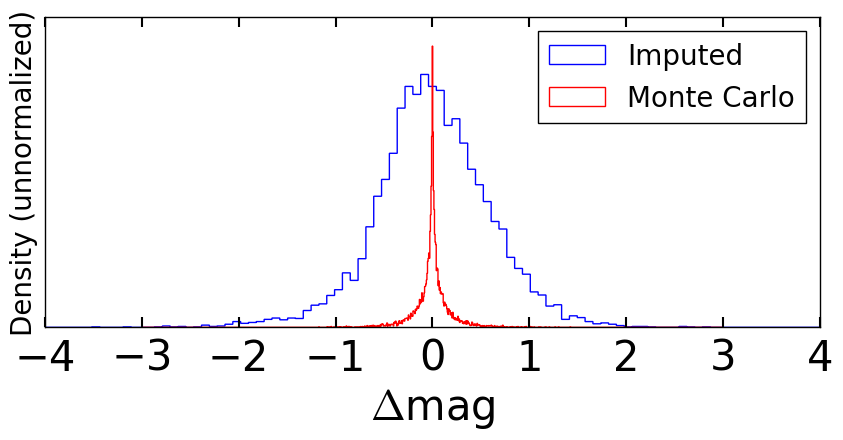

In [9]:
# plot mean deviation
figure(figsize=(10,4))
h=hist(mdev,histtype='step',bins=linspace(-4,4,100),color='blue',label='Imputed')
h=hist(mdev_mc,histtype='step',bins=linspace(-3,3,1000),color='red',label='Monte Carlo')
legend(fontsize=20)
xlabel('$\Delta$mag')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Mean offset (imputed):',mean(mdev)
print 'Mean offset (Monte Carlo):',mean(mdev_mc)

The distribution of imputed magnitude deviations over the population is unbiased, but significantly broader than what you'd expect just from measurement error. This makes some sense: we're trying to infer the magnitude without actually having measured it using "similar" objects, and there's only so far we can go with that.

The real question of course is how much of the broadening is due to small biases but large variation among individual objects (best case) vs small variation but large biases (worst case). This is shown below.

Median normalized offset (imputed): -0.0493543309814
Median normalized offset (Monte Carlo): -0.00956817271924


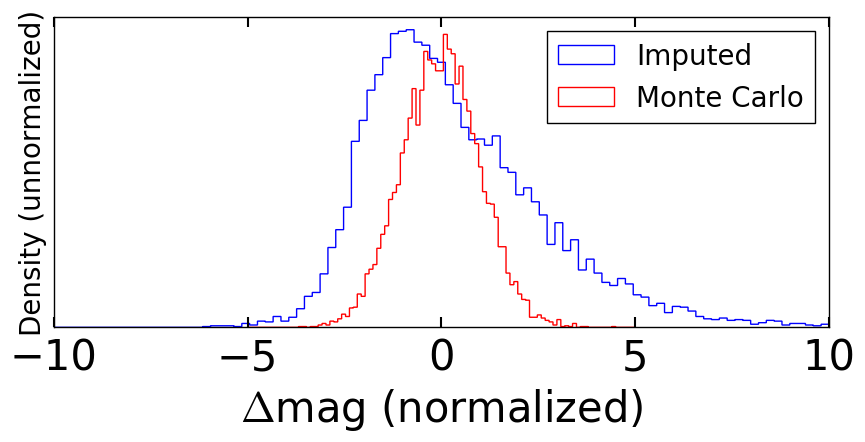

In [10]:
# plot mean normalized deviation
figure(figsize=(10,4))
h=hist(mdev_norm,histtype='step',bins=linspace(-10,10,100),color='blue',label='Imputed')
h=hist(mdev_mc_norm,histtype='step',bins=linspace(-5,5,100),color='red',label='Monte Carlo')
legend(fontsize=20)
xlabel('$\Delta$mag (normalized)')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median normalized offset (imputed):',median(mdev_norm)
print 'Median normalized offset (Monte Carlo):',median(mdev_mc_norm)

It looks like we're somewhere in-between: imputed magnitudes are biased, but the errors are significantly inflated to somewhat counteract this. The distribution is also markedly assymetric, with a long tail towards over-estimation compared with underestimation. The nature of this bias is shown below.

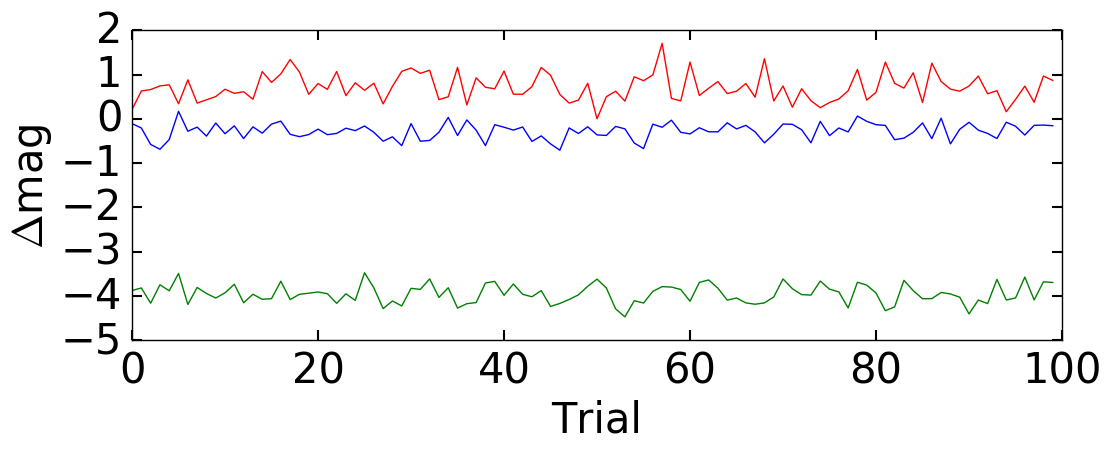

In [11]:
figure(figsize=(12,4))
plot(mag_d_impute[:,mask_d[sel][csel]==False][:,8]-mag_d[sel][csel][mask_d[sel][csel]==False][8])
plot(mag_d_impute[:,mask_d[sel][csel]==False][:,2]-mag_d[sel][csel][mask_d[sel][csel]==False][8])
plot(mag_d_impute[:,mask_d[sel][csel]==False][:,17]-mag_d[sel][csel][mask_d[sel][csel]==False][8])
xlabel('Trial')
ylabel('$\Delta$mag')

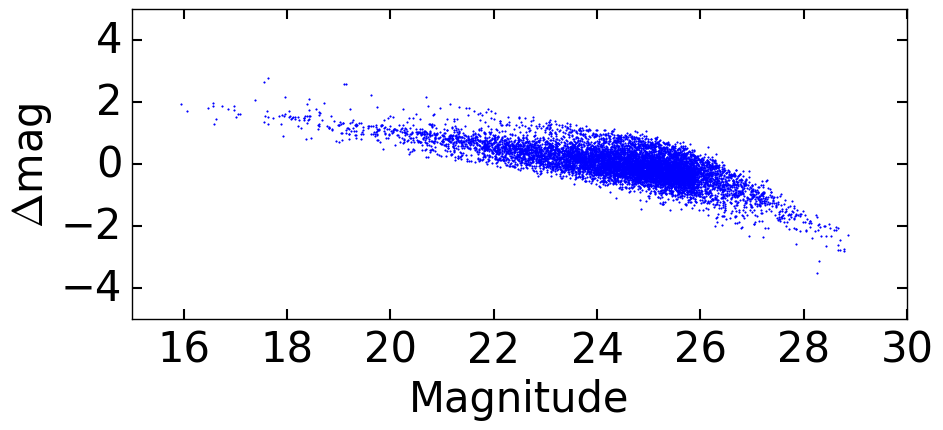

In [12]:
# plot magnitude-dmag trend
figure(figsize=(10,4))
plot(mag_d[sel][csel][mask_d[sel][csel]==False],mdev,'.',markersize=2)
xlim([15,30])
ylim([-5,5])
xlabel('Magnitude')
ylabel('$\Delta$mag')

There is a clear trend with magnitude, where brighter objects have their magnitudes overestimated (i.e. thought to be fainter), and fainter objects underestimated (i.e. thought to be brighter). This explains our previously observed trend, since underestimation shouldn't be a huge problem for the majority of objects in our sample at faint magnitude (since these are Luptitudes, the scale becomes approximately linear around $\sim 26$ mag where errors are already large), but overestimation is more serious at brighter magnitudes where the measured errors are smaller. This isn't necessarily what we want.

## WINBET: Weighted Inference with Naive Bayes and Extra Trees

To correct for some of the effects shown above, we need to take both of these factors into account. We accomplish this in four steps:

1. Impute missing data according to a **Naive Bayes** prior constructed from the marginal distribution in each band.
2. Find a set of neighbors without explicitly relying on distances using mappings created by **Extra Trees**.
3. Conduct targeted **inference** on those neighbors to derive a set of **likelihood weights**.
4. Estimate the photometry and variance using weights among all objects with non-missing values.

**WINBET** is implemented as a subroutine in FRANKEN-Z.

In [7]:
mag_train_d,magerr_train_d=mag_d[sel][train_sel],magerr_d[sel][train_sel] # training mags
mag_test_d,magerr_test_d=mag_d[sel][test_sel],magerr_d[sel][test_sel] # testing mags

In [14]:
winbet=fz.WINBET() # intialize WINBET (Ntrees=100,Nleaf=10)
winbet.train(phot_train_d,var_train_d,mask_train_d,mag_train_d,magerr_train_d,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

There are two imputation modes in WINBET: 'random' (random draw from neighbors) and 'mean' (generate weighted mean results). Let's try using the 'mean' predictions first.

In [15]:
p1,v1=winbet.impute(phot_train_d,var_train_d,mask_train_d,'mean')

0 500 1000 1500 2000 2500 3000 

Since it's easier to compare logarithmic performance, we convert our results back to magnitudes.

In [21]:
mcensor,mecensor=fz.asinh_mag_map(p1,sqrt(var_train_d),zeropoint=flux_zeropoint,skynoise=skynoise)
mcensor,mecensor2=fz.asinh_mag_map(p1,sqrt(v1),zeropoint=flux_zeropoint,skynoise=skynoise)
dev=(mcensor-mag_train_d)[mask_train_d==False]
dev_norm=dev/(mecensor[mask_train_d==False])
dev_norm2=dev/(mecensor2[mask_train_d==False])

mdev_mc=normal(zeros(len(dev)),magerr_train_d[mask_train_d==False]) # monte carlo
mdev_mc_norm=mdev_mc/magerr_train_d[mask_train_d==False]

Median offset (imputed): -0.0347364435959
Median offset (Monte Carlo): 0.00171866002859


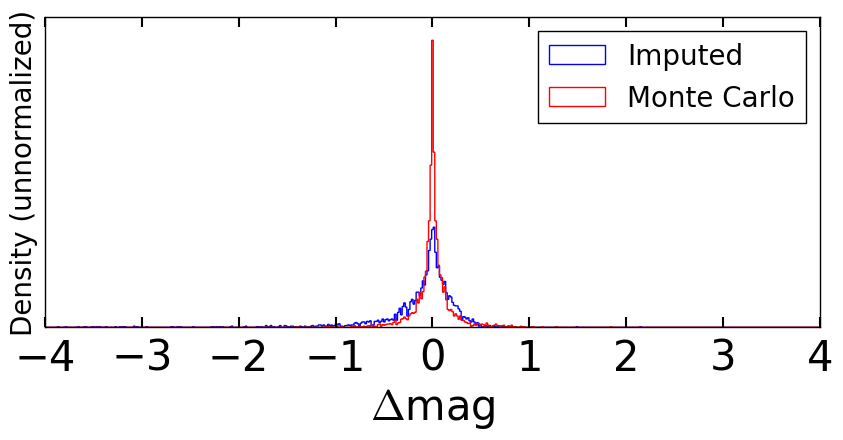

In [22]:
# plot mean deviation
figure(figsize=(10,4))
h=hist(dev,histtype='step',bins=linspace(-4,4,500),color='blue',label='Imputed',normed=True)
h=hist(mdev_mc,histtype='step',bins=linspace(-4,4,500),color='red',label='Monte Carlo',normed=True)
legend(fontsize=20)
xlabel('$\Delta$mag')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median offset (imputed):',median(dev)
print 'Median offset (Monte Carlo):',median(mdev_mc)

So far, this looks pretty good the overall spread is much smaller, and the estimates are not heavily biased.

Median normalized offset (imputed): -0.570352060994
Median normalized offset (Monte Carlo): 0.0496019510283


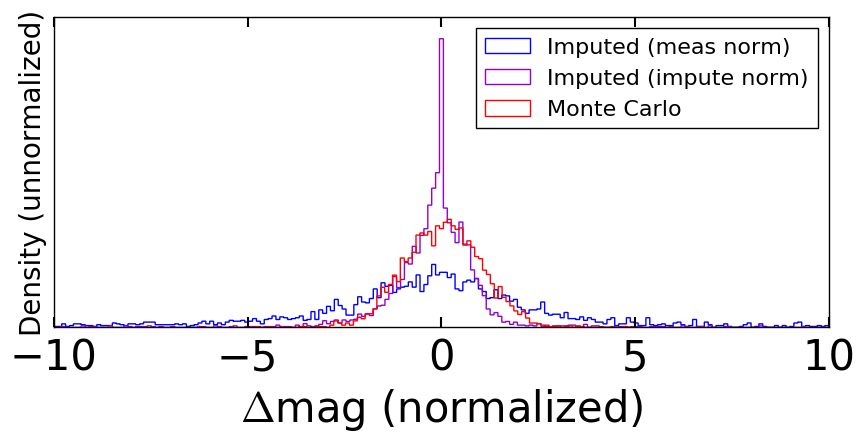

In [23]:
# plot mean normalized deviation
figure(figsize=(10,4))
h=hist(dev_norm,histtype='step',bins=linspace(-10,10,200),color='blue',label='Imputed (meas norm)',normed=True)
h=hist(dev_norm2,histtype='step',bins=linspace(-10,10,200),color='darkviolet',label='Imputed (impute norm)',normed=True)
h=hist(mdev_mc_norm,histtype='step',bins=linspace(-5,5,100),color='red',label='Monte Carlo',normed=True)
legend(fontsize=16)
xlabel('$\Delta$mag (normalized)')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median normalized offset (imputed):',median(dev_norm)
print 'Median normalized offset (Monte Carlo):',median(mdev_mc_norm)

Our normalized error distribution also looks much more like the expected distribution once we normalized by the estimated impute errors (rather than the actual measurement errors), although with somewhat broader tails.

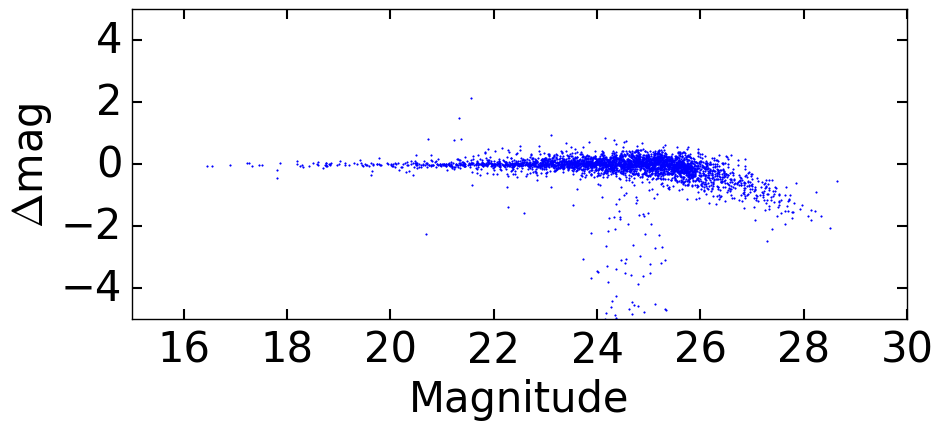

In [24]:
# plot magnitude-dmag trend
figure(figsize=(10,4))
plot(mag_train_d[mask_train_d==False],dev,'.',markersize=2)
xlim([15,30])
ylim([-5,5])
xlabel('Magnitude')
ylabel('$\Delta$mag')

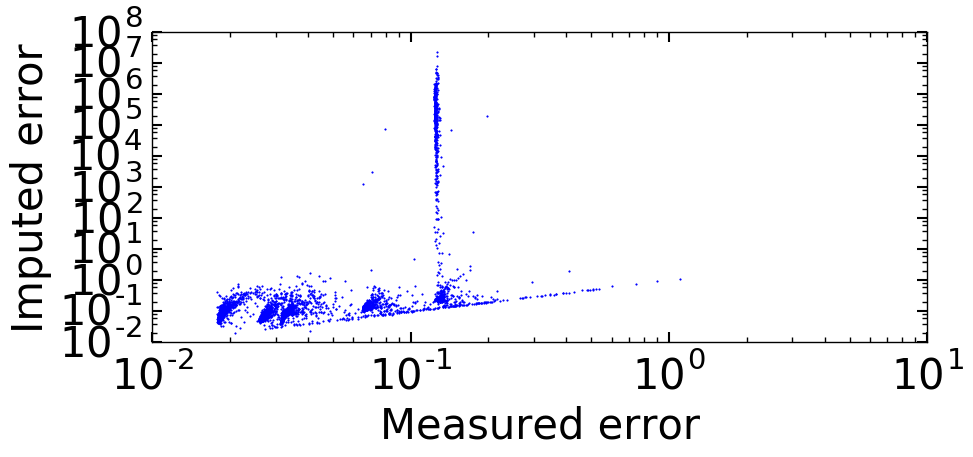

In [25]:
# plot measured ("true") vs imputed ("estimated") errors.
figure(figsize=(10,4))
loglog(sqrt(var_train_d)[mask_train_d==False],sqrt(v1)[mask_train_d==False],'.',markersize=2)
xlabel('Measured error')
ylabel('Imputed error')

Based on these plots, we confirm that not only do we do a much better job overall of computing the magnitudes compared to **fancyimpute**, the trend with magnitude is noticeably improved: most of the imputed photometry at higher magnitudes now follows a smooth 1:1 relation, while at lower mags near the sky background limit there is a clear downward trend that is small compared to the sky background. 

We note that the tail of errors indicates we have hit a degeneracy between faint fluxes and bright fluxes, which is likely a manifestation of the well-known high-/low-$z$ degeneracy.

In addition to the **mean**-based estimates shown above, the **WINBET** method as implemented in FRANKEN-Z also contains a **random**-based estimate. This is more useful if we want to generate content "on-the-fly", rather than ahead of time, since the imputed distribution might be non-Gaussian, have widely-separated modes, and subject to strong covariances.

In [26]:
runs=[winbet.impute(phot_train_d,var_train_d,mask_train_d,impute_type='random') for i in xrange(20)]

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 

In [27]:
mcensors=[fz.asinh_mag_map(runs[i][0],sqrt(var_train_d),zeropoint=flux_zeropoint,skynoise=skynoise) for i in xrange(20)]
mcensors2=[fz.asinh_mag_map(runs[i][0],sqrt(runs[i][1]),zeropoint=flux_zeropoint,skynoise=skynoise) for i in xrange(20)]
dev=array([(mcensors[i][0]-mag_train_d)[mask_train_d==False] for i in xrange(20)])
dev_norm=array([dev[i]/(mcensors[i][1][mask_train_d==False]) for i in xrange(20)])
dev_norm2=array([dev[i]/(mcensors2[i][1][mask_train_d==False]) for i in xrange(20)])

Median offset (imputed): -0.00958414701195
Median offset (Monte Carlo): 0.00171866002859


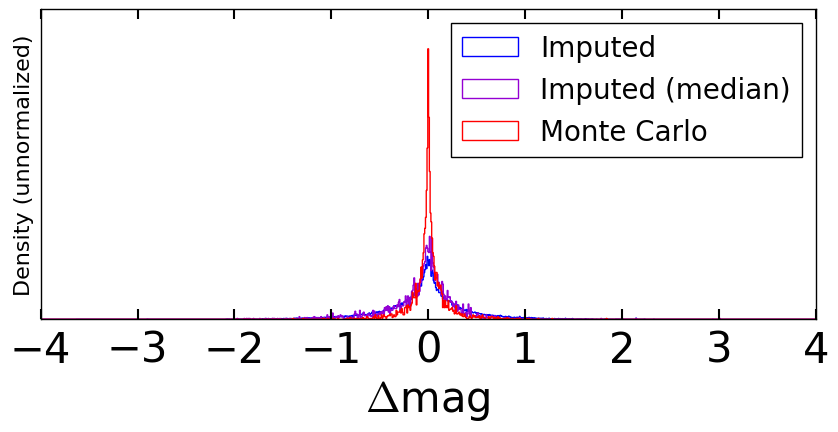

In [28]:
# plot mean deviation
figure(figsize=(10,4))
h=hist(dev.flatten(),histtype='step',bins=linspace(-4,4,1000),color='blue',label='Imputed',normed=True)
h=hist(median(dev,axis=0),histtype='step',bins=linspace(-4,4,1000),color='darkviolet',label='Imputed (median)',normed=True)
h=hist(mdev_mc,histtype='step',bins=linspace(-4,4,1000),color='red',label='Monte Carlo',normed=True)
legend(fontsize=20)
xlabel('$\Delta$mag')
ylabel('Density (unnormalized)',fontsize=16)
yticks([])

print 'Median offset (imputed):',median(dev.flatten())
print 'Median offset (Monte Carlo):',median(mdev_mc)

We notice that the general distribution is broader, as we'd expect, but that the median predictors (mirroring the mean predictors above) does indeed trace the true distribution.

Median normalized offset (meas norm): -0.158206232501
Median normalized offset (impute norm): -0.158334239226
Median normalized offset (median): -0.148705387796
Median normalized offset (Monte Carlo): 0.0496019510283


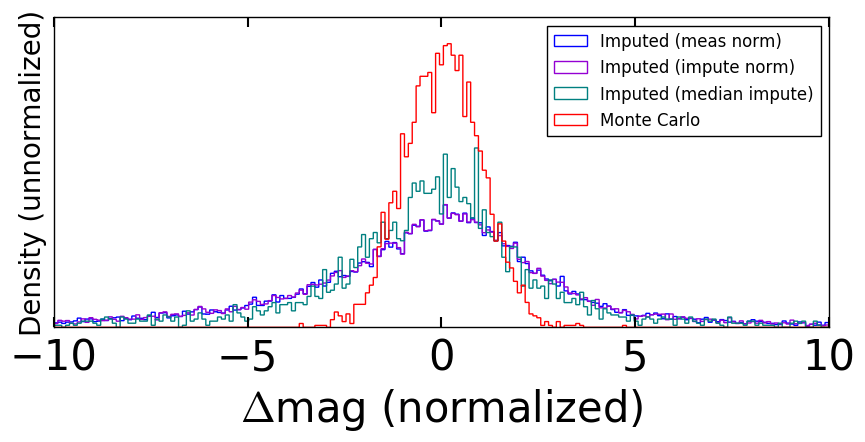

In [29]:
# plot mean normalized deviation
figure(figsize=(10,4))
h=hist(dev_norm.flatten(),histtype='step',bins=linspace(-10,10,200),color='blue',label='Imputed (meas norm)',normed=True)
h=hist(dev_norm2.flatten(),histtype='step',bins=linspace(-10,10,200),color='darkviolet',
       label='Imputed (impute norm)',normed=True)
h=hist(median(dev_norm2,axis=0),histtype='step',bins=linspace(-10,10,200),color='teal',
       label='Imputed (median impute)',normed=True)
h=hist(mdev_mc_norm,histtype='step',bins=linspace(-10,10,200),color='red',label='Monte Carlo',normed=True)
legend(fontsize=12)
xlabel('$\Delta$mag (normalized)')
ylabel('Density (unnormalized)',fontsize=20)
yticks([])

print 'Median normalized offset (meas norm):',median(dev_norm)
print 'Median normalized offset (impute norm):',median(dev_norm2)
print 'Median normalized offset (median):',median(median(dev_norm2,axis=0))
print 'Median normalized offset (Monte Carlo):',median(mdev_mc_norm)

If we just look at the formal measurement error **from each random realization**, we underestimate the errors. This isn't too surprising, given we expect the variance across observations to be significant.

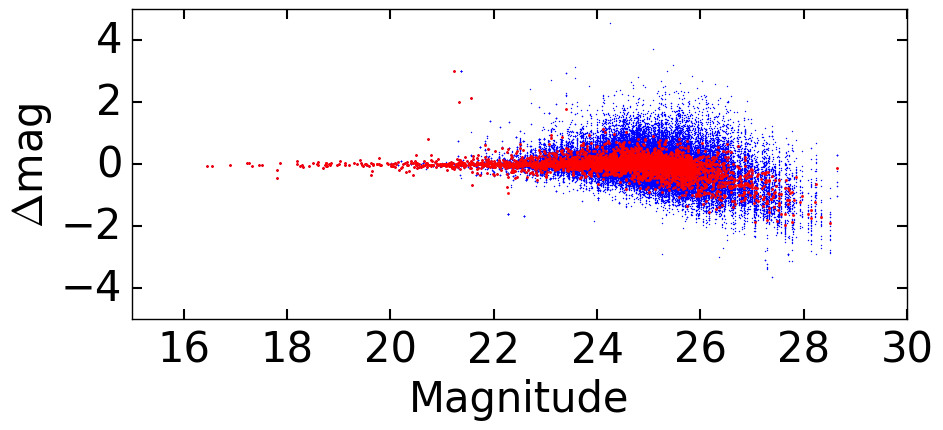

In [30]:
# plot magnitude-dmag trend
figure(figsize=(10,4))
[plot(mag_train_d[mask_train_d==False],dev[i],'b.',markersize=1) for i in xrange(20)]
plot(mag_train_d[mask_train_d==False],median(dev,axis=0),'r.',markersize=3)
xlim([15,30])
ylim([-5,5])
xlabel('Magnitude')
ylabel('$\Delta$mag')

As expected, the variance across observations is larger than any individual error (as shown by the scatter about the median).

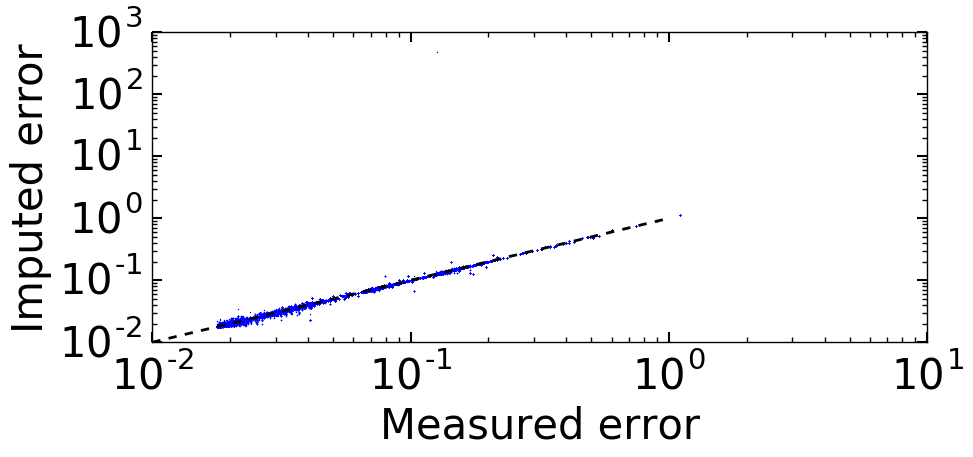

In [31]:
# plot measured ("true") vs imputed ("estimated") errors.
figure(figsize=(10,4))
[loglog(sqrt(var_train_d)[mask_train_d==False],sqrt(runs[i][1])[mask_train_d==False],'b.',markersize=1) for i in xrange(20)]
plot([1e-2,1e0],[1e-2,1e0],'k--',lw=2)
xlabel('Measured error')
ylabel('Imputed error')

As the error plot above shows, however, **for a given realization**, we are actually in the same error regime as the original observation. This is another way of visualizing that the population variance at a given magnitude (i.e. at a given depth) is larger than the formal measurement error. Or to put it another way, there's a broader range of SEDs permitted at a given (unknown) magnitude than the formal measurement error for any individual SED given by the other magnitudes. We also see a few draws of largely-discrepant errors, confirming the broad swath of mean fits were caused by these degeneracies.

## Implementation with FRANKEN-Z

In [44]:
# initialize FRANKEN-Z instance
frankenz=fz.FRANKENZ(N_members=10) # default values: N_MC=100, N_neighbors=10

In [45]:
# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(phot_train_d,var_train_d,mask_train_d,mag_train_d,magerr_train_d,mdict)
winbet_test.train(phot_test_d,var_test_d,mask_test_d,mag_test_d,magerr_test_d,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

We'll demonstrate two ways to impute data: pre-filling the arrays using mean-generated data, and generating data "on the fly" by passing the WINBET classes to FRANKEN-Z directly.

In [46]:
# compute mean quantities
p1,v1=winbet_train.impute(phot_train_d,var_train_d,mask_train_d,impute_type='mean')
p2,v2=winbet_test.impute(phot_test_d,var_test_d,mask_test_d,impute_type='mean')

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

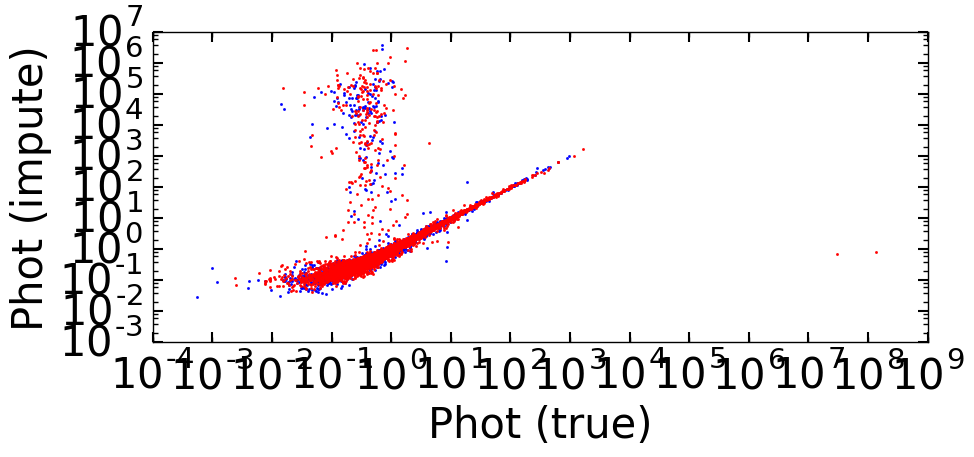

In [47]:
# plot photometric reconstruction
figure(figsize=(10,4))
loglog(phot_train_d[mask_train_d==False],p1[mask_train_d==False],'b.',markersize=3)
loglog(phot_test_d[mask_test_d==False],p2[mask_test_d==False],'r.',markersize=3)
xlabel('Phot (true)')
ylabel('Phot (impute)')

In [48]:
# compute quantities
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,sqrt(v1),mask_train_d,p2,sqrt(v2),mask_test_d)

0 1 2 3 4 5 6 7 8 9 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


In [49]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum()/Nm)+model_llmin[i] # -2ln(Evidence), normalized to number of objects used in fit
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 

Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


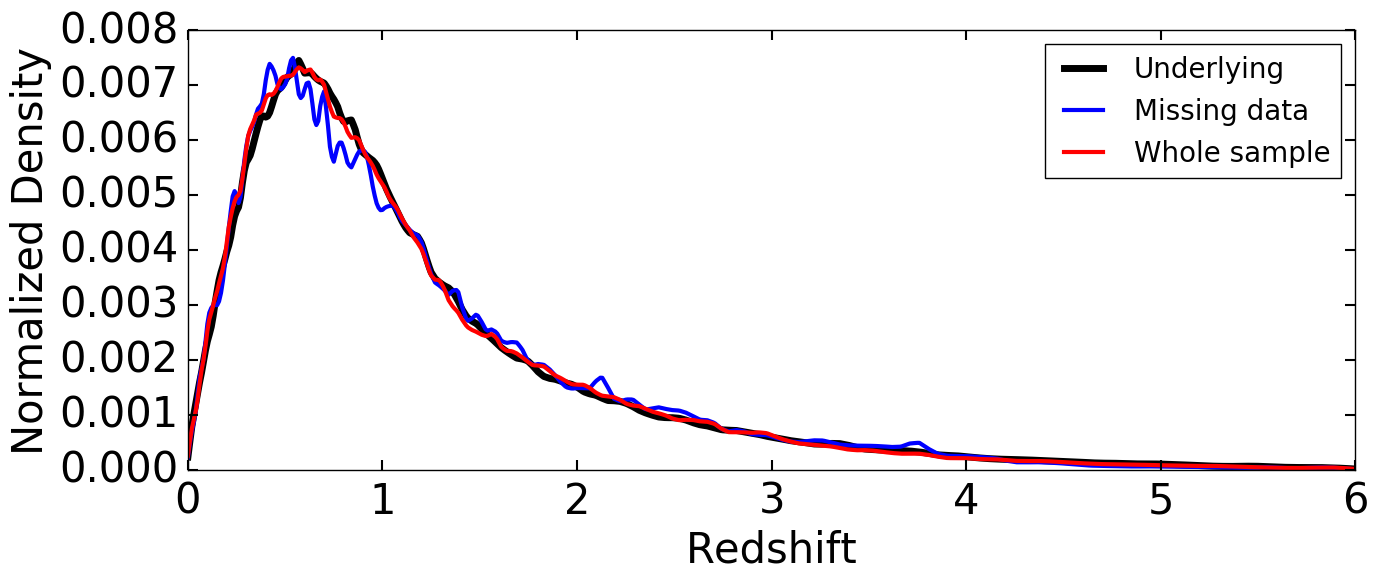

In [50]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf_fz[csel[test_sel]],axis=0)/sum(csel[test_sel]),lw=3,color='blue',label='Missing data')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=3,color='red',label='Whole sample')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

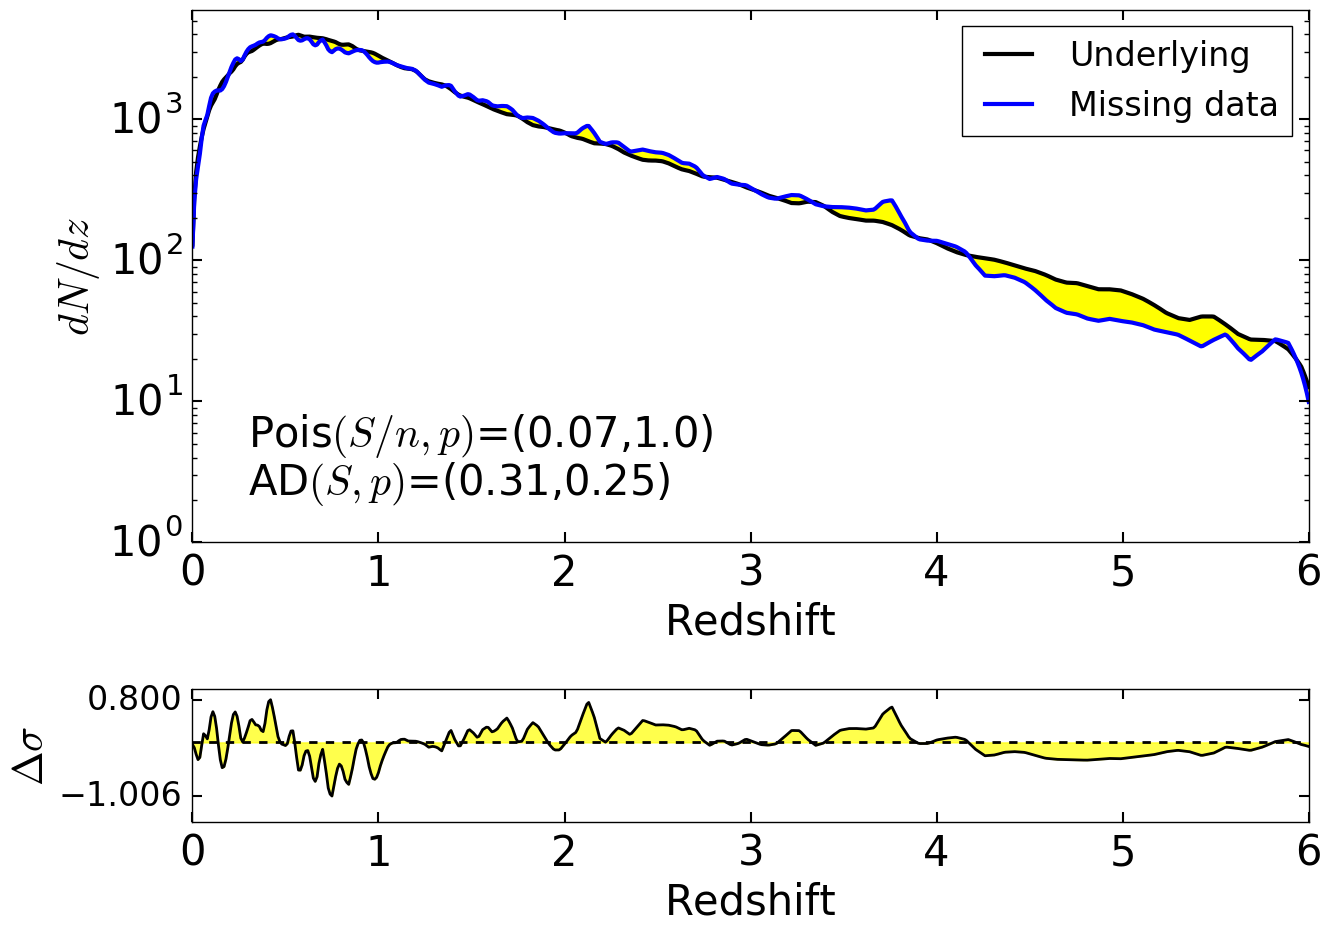

In [51]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*sum(csel[test_sel]),nansum(zpdf_fz[csel[test_sel]],axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Missing data'],colors=['black','blue'])

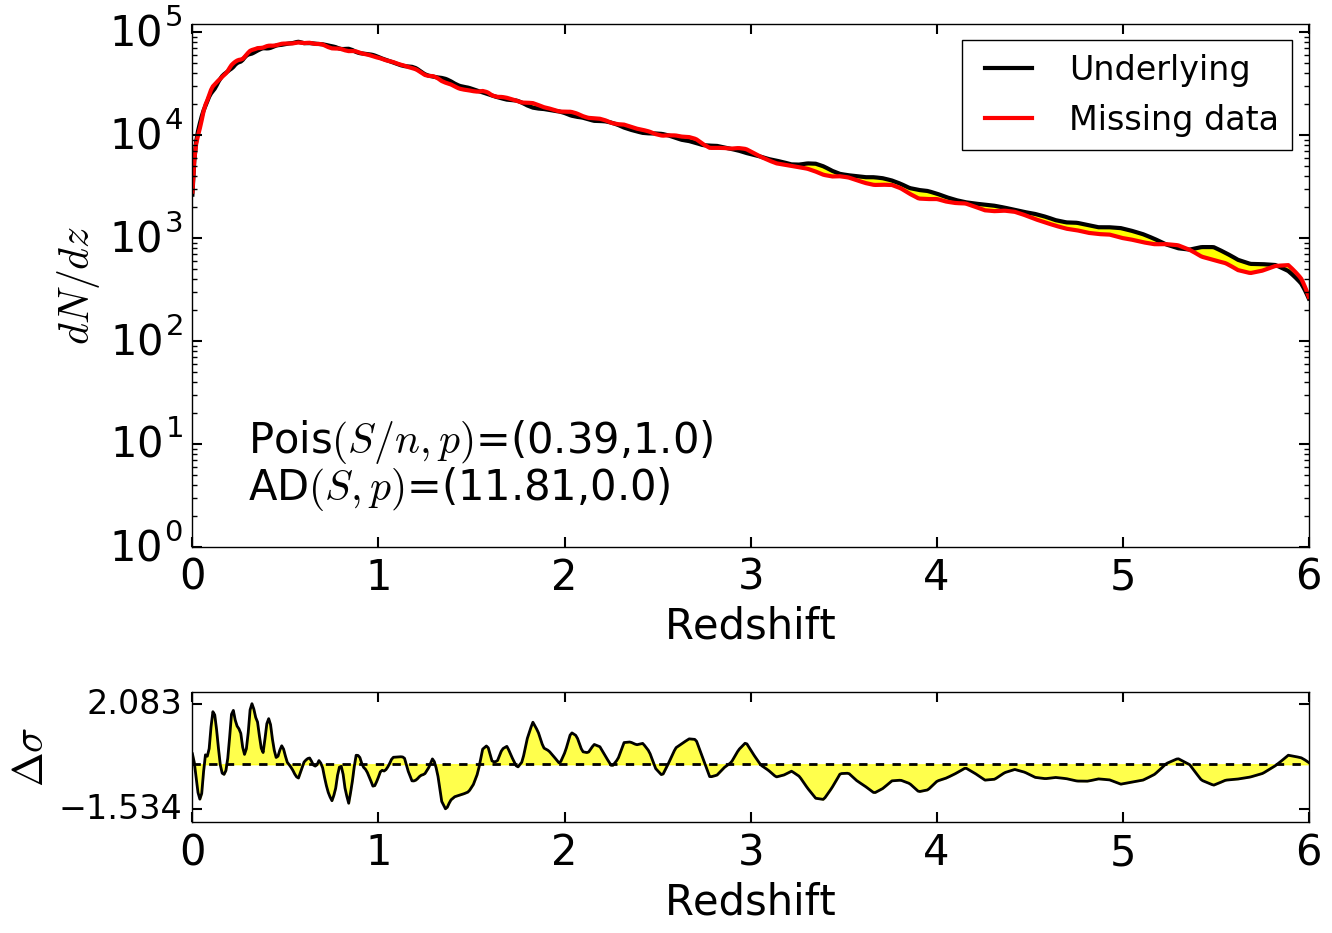

In [52]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,nansum(zpdf_fz,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Missing data'],colors=['black','red'])

That looks pretty good! Let's now try the on-the-fly predictions. This obviously is $N_{MC}$ times slower than just generating a set of predictions once, but should allow us to better model imputed object flux/error covariances.

In [53]:
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,sqrt(v1),mask_train_d,p2,sqrt(v2),mask_test_d,
                                                            impute_train=winbet_train,impute_test=winbet_test)

0 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

1 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

2 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

3 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

4 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

5 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

6 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

7 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

8 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

9 

0 500 1000 1500 2000 2500 3000 0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


In [54]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum()/Nm)+model_llmin[i] # -2ln(Evidence), normalized to number of objects used in fit
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 

Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


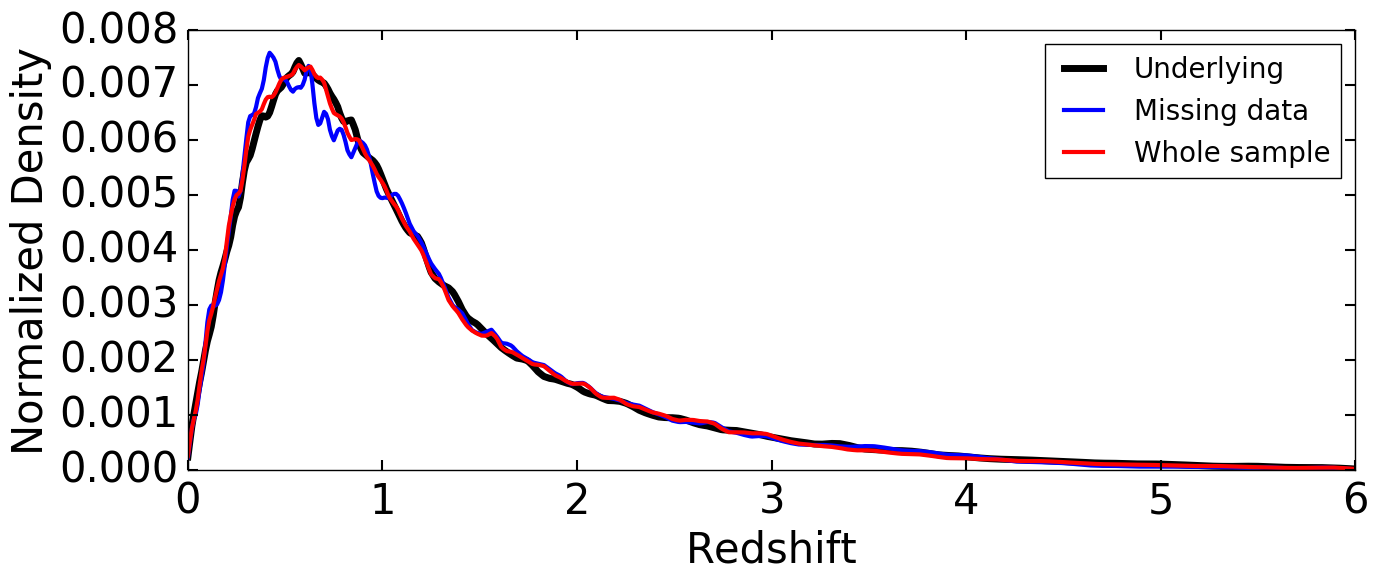

In [55]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf_fz[csel[test_sel]],axis=0)/sum(csel[test_sel]),lw=3,color='blue',label='Missing data')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=3,color='red',label='Whole sample')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

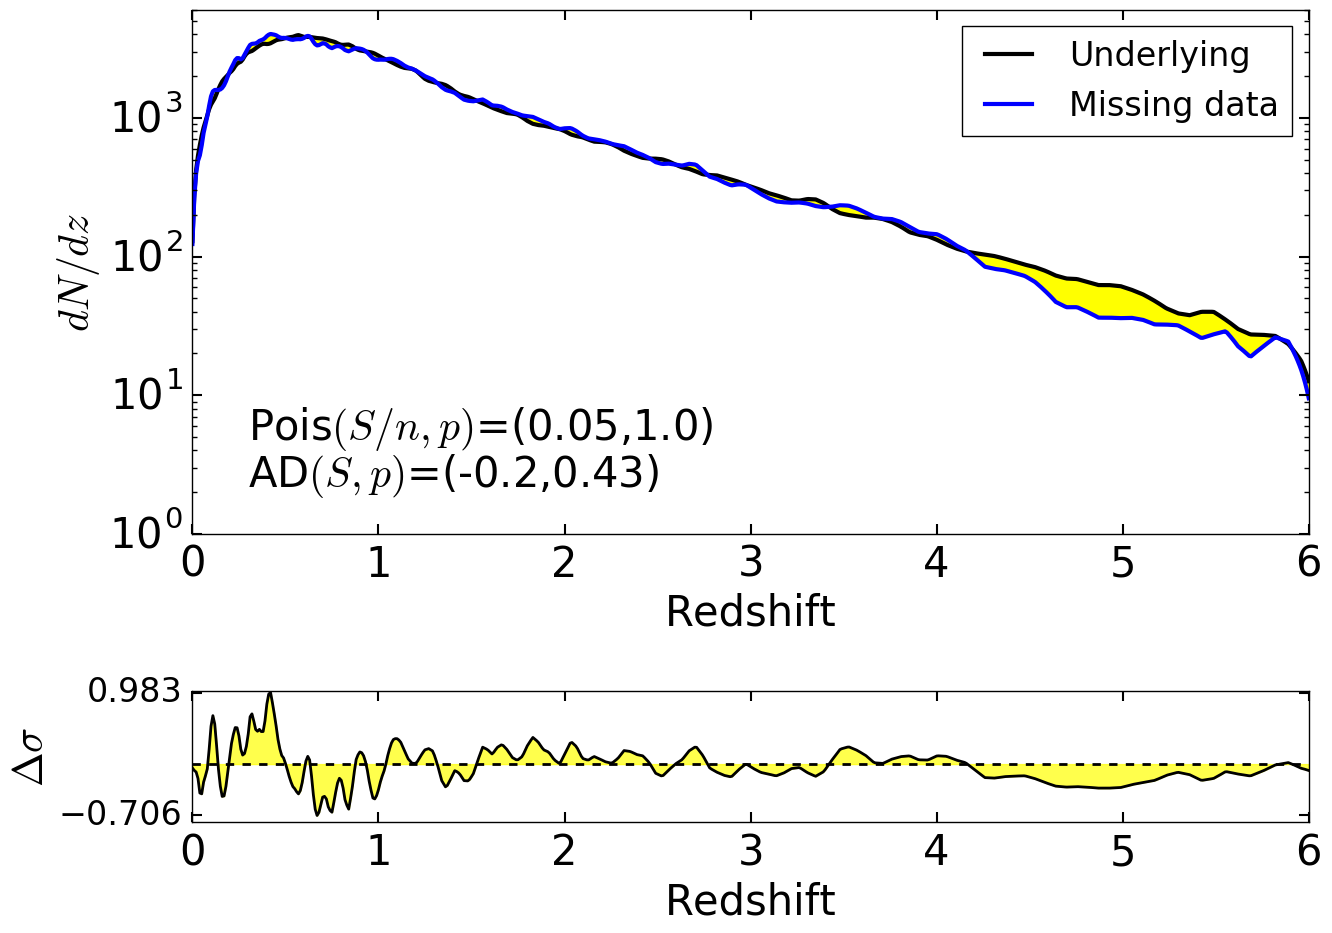

In [56]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*sum(csel[test_sel]),nansum(zpdf_fz[csel[test_sel]],axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Missing data'],colors=['black','blue'])

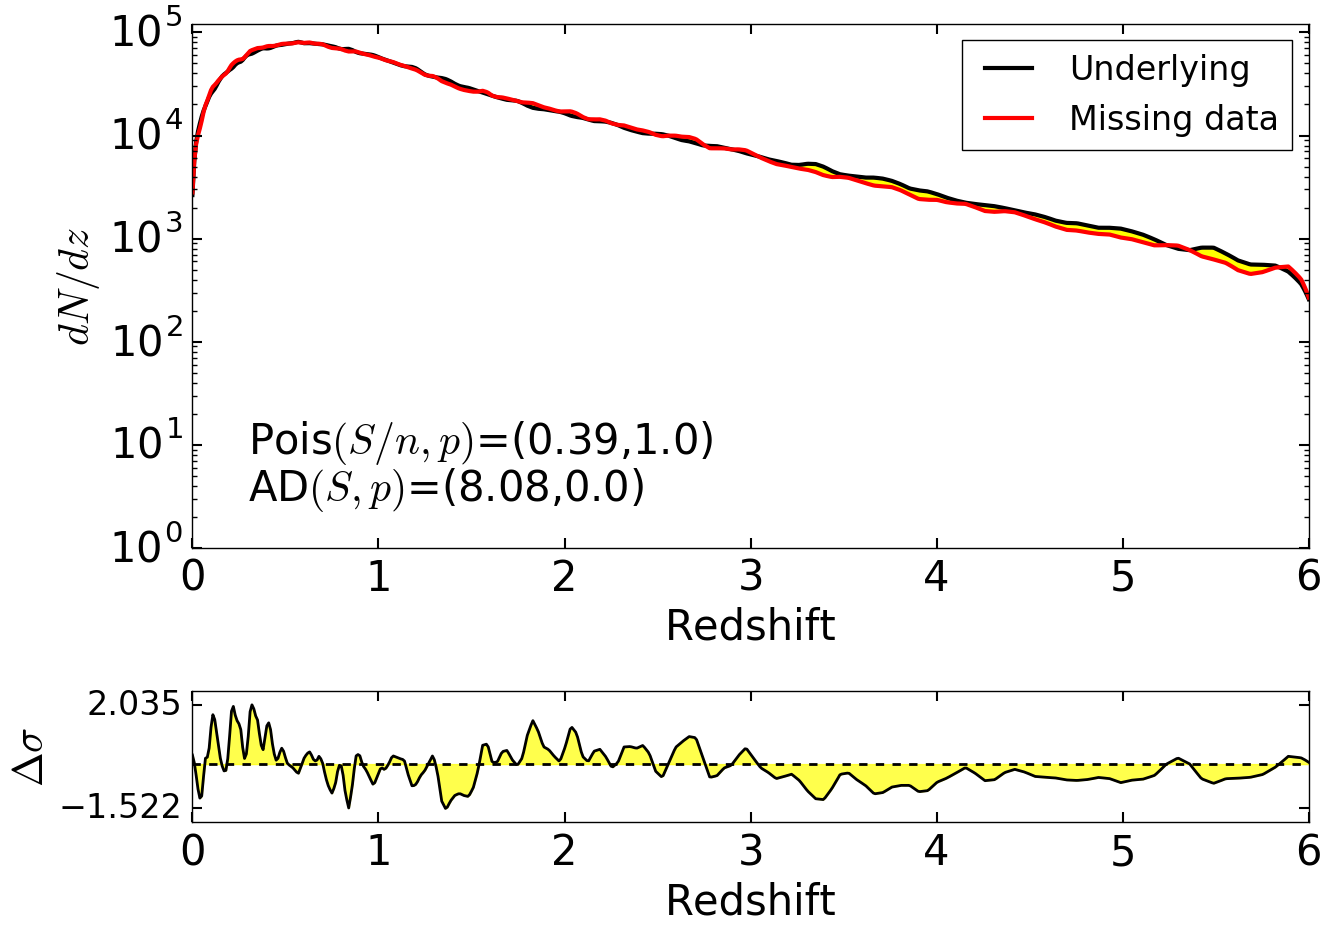

In [57]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,nansum(zpdf_fz,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Missing data'],colors=['black','red'])

Both look quite comparable.